# EDA Part -1 :

This notebook contains basic exploration around the `Mercari Dataset`. 

In [16]:
# import essentials
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import scipy.stats as stats
from tqdm import tqdm
import pickle
# from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Load the dataset:

In [5]:
cd ..

/Users/mehuljain/Documents/course_related/ML_Ops/project/Price_Alchemy


In [6]:
ls "data/Mercari Price Suggestion Challenge/"

sample_submission.csv           test.tsv.7z
sample_submission.csv.7z        test_stg2.tsv
sample_submission_stg2.csv      test_stg2.tsv.zip
sample_submission_stg2.csv.zip  train.csv
test.csv                        train.tsv
test.tsv                        train.tsv.7z


In [9]:
# df=pd.read_csv('./data/Mercari Price Suggestion Challenge/train.tsv', sep='\t', header=0)
df=pd.read_csv('./data/Mercari Price Suggestion Challenge/train.csv')

What does our dataset look like?

In [10]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


## Basic EDA:

There is a `item_condition_id` column in the dataset. How many unique values does this column have?

In [7]:
df.item_condition_id.unique()

array([3, 1, 2, 4, 5])

How many item categories do we have?

In [8]:
df.category_name.nunique()

1287

How many brand names?

In [9]:
df.brand_name.nunique()

4809

What's the distribution of the `price` variable?

In [10]:
df['price'].min(), df['price'].max()

(0.0, 2009.0)

/Users/mehuljain/miniconda3/envs/mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


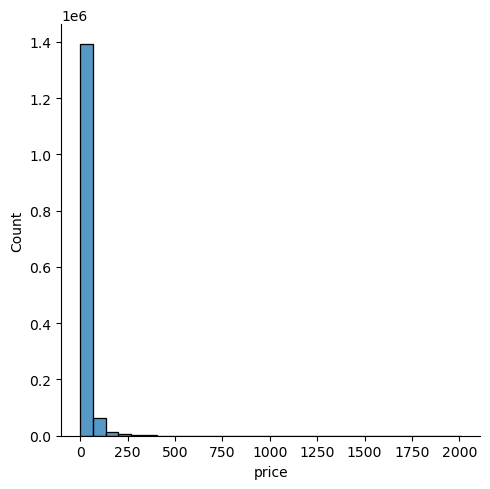

In [11]:
sns.displot(df, x="price", bins=30)

In [14]:
# standard deviation
df['price'].std()

38.586066313339806

In [15]:
# mean of the data
df['price'].mean()

26.737516146330442

In [21]:
# z-score of the data
stats.zscore(df['price'].values).max()

51.37251193984388

As expected, most of the items lie on the lower side of the spectrum. 

/Users/mehuljain/miniconda3/envs/mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


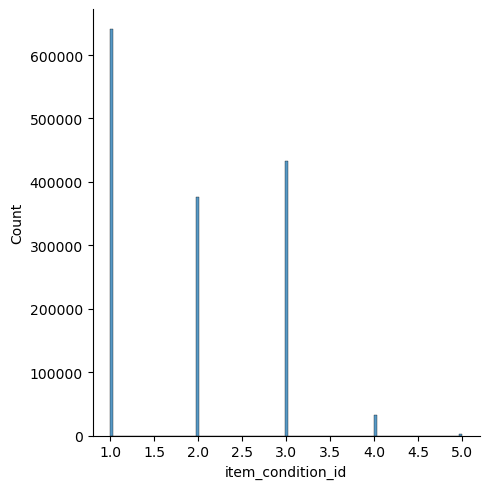

In [12]:
sns.displot(df, x="item_condition_id")

Interesting! Most of the items on the platform have an item condition id of `1`. Which means a lot of the items on the platform are old. There are very less items which are new/close to new ( item condition id  is 5 ).

Do sellers usually pay for shipping or not?

/Users/mehuljain/miniconda3/envs/mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


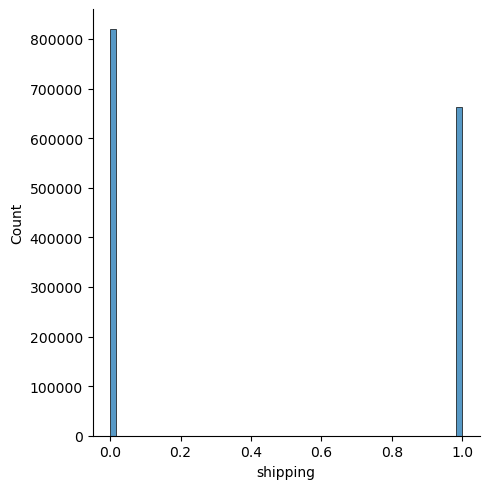

In [13]:
sns.displot(df, x="shipping")

## Word Map:
Let's do some basic text preprocessing and create some word maps.

In [14]:
raw_text= df['item_description'].to_list()

In [15]:
def preprocess(data):
    
    corpus=[]
    ps=PorterStemmer()
    
    for i in tqdm(data):
        
        try:
            dis=re.sub(r'https?:\/\/.*[\r\n]*', '',i)  #removing hyperlinks
            dis=re.sub(r'http?:\/\/.*[\r\n]*', '',dis) #removing hyperlinks
            #dis=re.sub(r'\@[a-zA-Z0-9]\w+'," ",dis) # removing account mentions actually decreases the accuracy of the model 
            dis=re.sub('[^a-zA-Z]'," ",dis) #removing punctuation marks and numbers
            dis=dis.lower() # converting into lower case
            dis=dis.split() # splitting 
            dis=[ps.stem(word) for word in dis if not word in set(stopwords.words("english"))]  #stemming the words to trim down the number of words
            dis=' '.join(dis)
            corpus.append(dis)
            
        except:
            corpus.append(f"<BAD> {i}")
    
    return corpus

Preprocess the raw text 

In [16]:
# data_final= preprocess(raw_text)

100%|████████████████████████████████| 1482535/1482535 [45:10<00:00, 547.05it/s]


Dump data 

In [17]:
# with open('./data/mercari_processed.pkl', 'wb') as f:
#     pickle.dump(data_final,f)

Load data

In [19]:
with open('./data/mercari_processed.pkl', 'rb') as f:
    processed_data= pickle.load(f)

Word cloud using all of the data:

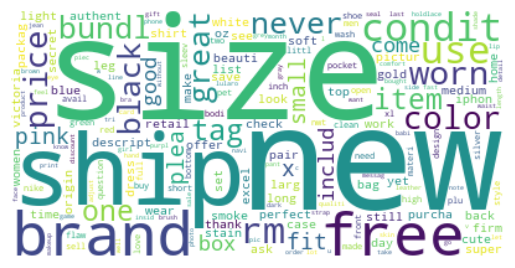

In [25]:
text = " ".join(i for i in processed_data)

print
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Deep dive:

What are the top categories for products in the dataset?

In [36]:
most_cats=df.groupby('category_name').count().sort_values(by="train_id",ascending=False)['train_id']

In [37]:
most_cats

category_name
Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Vintage & Collectibles/Supplies/Ephemera              1
Handmade/Paper Goods/Pad                              1
Handmade/Geekery/Videogame                            1
Handmade/Woodworking/Seasonal                         1
Other/Magazines/International Publications            1
Name: train_id, Length: 1287, dtype: int64

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482529 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


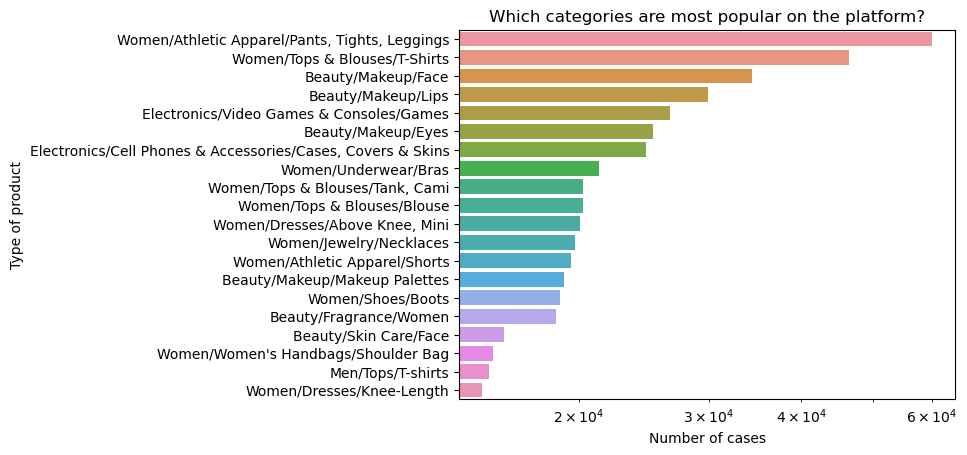

In [42]:
#1
most_cats_df=most_cats.reset_index().head(20)
g=sns.barplot(x=most_cats_df["train_id"], y= most_cats_df["category_name"])
g.set_xscale("log")
g.set_title('Which categories are most popular on the platform?')

_ = g.set(xlabel="Number of cases", ylabel="Type of product")

The top 20 categories contains products that are mainly catering to women. Most of them relate to women's clothing or beauty products.

Now, let's look at the top 20 brands that are most popular on the platform.

In [43]:
most_brands=df.groupby('brand_name').count().sort_values(by="train_id",ascending=False)['train_id']

In [44]:
most_brands

brand_name
PINK                    54088
Nike                    54043
Victoria's Secret       48036
LuLaRoe                 31024
Apple                   17322
                        ...  
Linea Pelle                 1
Lime Crime Cosmetics        1
Lilu                        1
Lillie Rubin                1
wallis                      1
Name: train_id, Length: 4809, dtype: int64

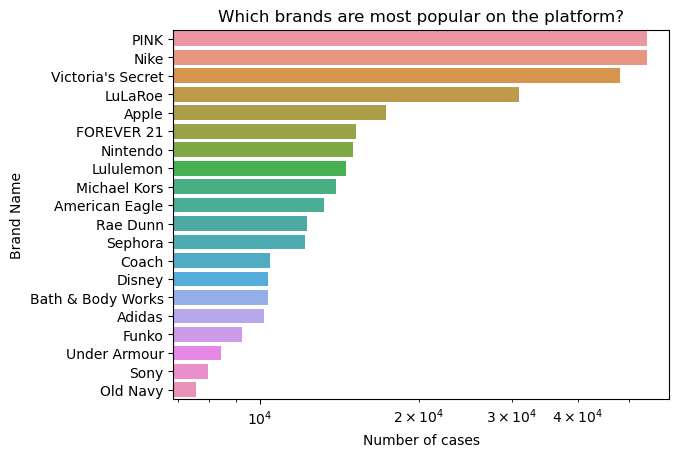

In [45]:
# 2
most_brands_df=most_brands.reset_index().head(20)
g=sns.barplot(x=most_brands_df["train_id"], y= most_brands_df["brand_name"])
g.set_xscale("log")
g.set_title('Which brands are most popular on the platform?')

_ = g.set(xlabel="Number of cases", ylabel="Brand Name")

PINK and Nike are the most popular brands on the platform (brands with the highest number of listings).  

### Dealing with expensive products on the platform:

In [47]:
# Get the price column
data = df.price

# Calculate quartiles
q1 = data.quantile(0.25)
q2 = data.quantile(0.5)  # This is the median
q3 = data.quantile(0.75)

# What are the first, second and third quartiles
print("Q1:", q1)
print("Q2 (median):", q2)
print("Q3:", q3)

Q1: 10.0
Q2 (median): 17.0
Q3: 29.0


How many products are above the third quartile?

In [60]:
df_third_quartile=df[df['price']>29]
df_third_quartile.shape[0]

368126

Let's zoom-in on this data. First, let's see the distribution of the data points in the third quartile.

/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_7145/4079743853.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_third_quartile.fillna(0, inplace=True)
/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_7145/4079743853.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
/Users/mehuljain/miniconda3/envs/mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


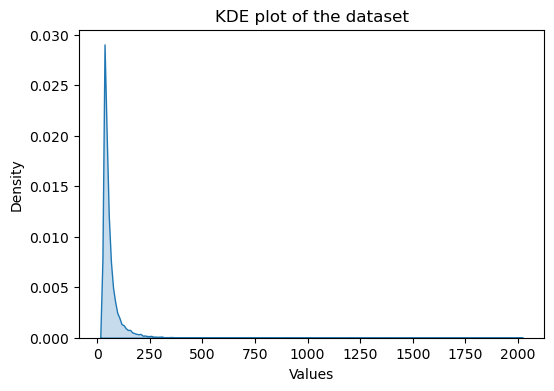

In [62]:
df_third_quartile.fillna(0, inplace=True)
data= df_third_quartile.price

plt.figure(figsize=(6, 4))
sns.kdeplot(data, shade=True)
plt.title('KDE plot of the dataset')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

As seen in the figure above, the number of the products drastically decreases after the `$250` mark. How many products have a price more than `$250`. And, should they be considered as outliers?

In [70]:
p_age= df[df['price']>250].shape[0]/df.shape[0]
print(f"How many products are worth more than $250: {df[df['price']>250].shape[0]}")
print(f"How much percentage of the dataset is it: {p_age *100 : .2f} %")

How many products are worth more than $250: 6127
How much percentage of the dataset is it:  0.41 %


What about products worth more than `$100`?

In [71]:
df[df['price']>100].shape[0]

41892

What brands do these products belong to?

In [73]:
df_above_100= df[df['price']>100]
most_brands=df_above_100.groupby('brand_name').count().sort_values(by="train_id",ascending=False)['train_id']

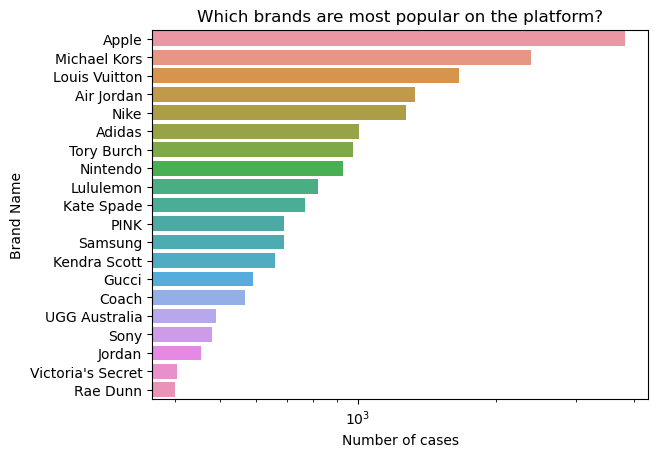

In [74]:
most_brands_df=most_brands.reset_index().head(20)
g=sns.barplot(x=most_brands_df["train_id"], y= most_brands_df["brand_name"])
g.set_xscale("log")
g.set_title('Which brands are most popular on the platform?')

_ = g.set(xlabel="Number of cases", ylabel="Brand Name")

What category do these products belong to?

In [75]:
most_cats=df_above_100.groupby('category_name').count().sort_values(by="train_id",ascending=False)['train_id']

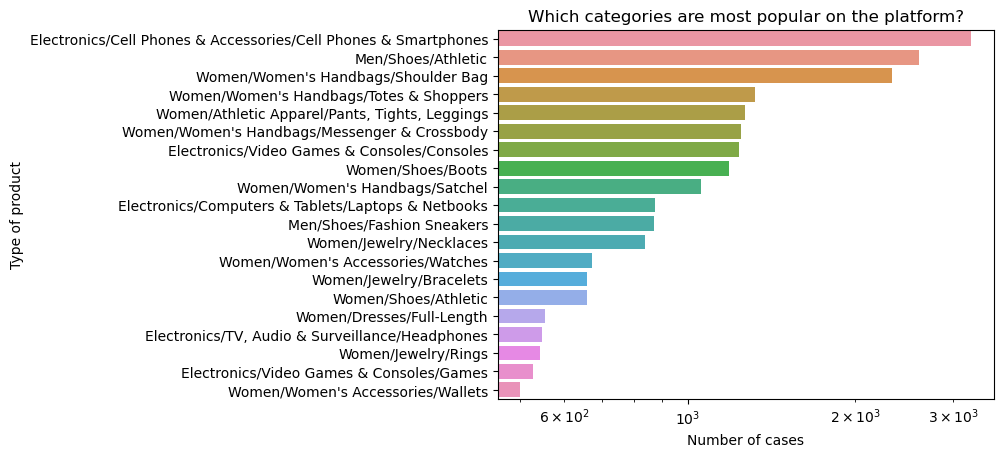

In [76]:
most_cats_df=most_cats.reset_index().head(20)
g=sns.barplot(x=most_cats_df["train_id"], y= most_cats_df["category_name"])
g.set_xscale("log")
g.set_title('Which categories are most popular on the platform?')

_ = g.set(xlabel="Number of cases", ylabel="Type of product")

What is their item condition?

/var/folders/ln/ryk6y70j7rg4321f6rt3hxx80000gn/T/ipykernel_7145/1280740412.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data, shade=True)
/Users/mehuljain/miniconda3/envs/mlops/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


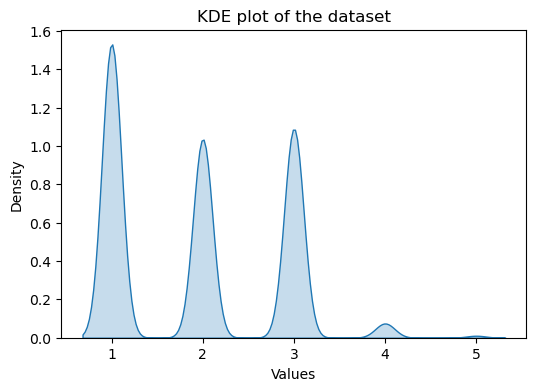

In [81]:
data= df_above_100.item_condition_id

plt.figure(figsize=(6, 4))
sns.kdeplot(data, shade=True)
plt.title('KDE plot of the dataset')
plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

Top 20 most expensive products?

In [84]:
df.sort_values(by='price', ascending=False).head(20)[['name', 'category_name','brand_name','price']]

,name,category_name,brand_name,price
760469,NEW Chanel WOC Caviar Gold Hardware,Women/Women's Handbags/Shoulder Bag,Chanel,2009.0
1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,Women/Women's Handbags/Messenger & Crossbody,Chanel,2006.0
1393600,David Yurman Wheaton ring,Women/Jewelry/Rings,David Yurman,2004.0
742113,Chanel Chevron Fuschia Pink 2,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0
956343,Chanel Black wallet on chain,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0
1445348,Vs2/I 1ct Diamond Engagement Ring,Women/Jewelry/Rings,NaN,2000.0
778940,Mary kay,Beauty/Makeup/Face,Mary Kay,2000.0
415027,Chanel Classic Jumbo Single flap bag,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0
1250053,Brand New Chanel CC Quilted WOC,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0
952000,Chanel J12 H0682 Wrist Watch for Women,Women/Women's Accessories/Watches,NaN,1999.0


From the above two plots, we can draw the following conclusions:
- Products above $100  can be:
    - Apple electronics 
    - Women's Hand bags (Michael Kors, Chanel and Louis Vuitton) 
    - Nike air jordans and other shoes 
- Most of the products are old (their item condition is 1). 
- The number of products decreases exponentially as the price increases. 